# PROJET N° 7 - Implémenter un modèle de scoring
## Partie 3 : Modélisation avec l'ensemble des 1242 features obtenues au terme du 'feature engineering' 
#### Auteur : Henrique DA COSTA
#### Date : Septembre 2021

# Plan <a class="anchor" id="plan"></a>

### [1. Importation des bibliothèques](#1)<a class="anchor" id="plan"></a>
### [2. Préparation des jeux de données](#2)<a class="anchor" id="plan"></a>
### [3. Initialisation de la modélisation avec la librairie Pycaret](#3)<a class="anchor" id="plan"></a>
### [4. Modèle LDA (Linear Discriminant Analysis)](#4)<a class="anchor" id="plan"></a>
### [5. Modèle XGBOOST](#5)<a class="anchor" id="plan"></a>
### [6. Modèle Lightgbm](#6)<a class="anchor" id="plan"></a>
### [7. Tester les 3 modèles](#7)<a class="anchor" id="plan"></a>
### [8. Préparation des jeux de données pour le dashboard avec le framework Streamlit](#8)<a class="anchor" id="plan"></a>

### -------------------------------------------------------------------------------------------------------------------------------

## [1. Importation des bibliothèques](#plan)<a class="anchor" id="1"></a>

In [4]:
# importation de structures de données 
import pandas as pd
import numpy as np
from scipy.stats import uniform

# importation de bibliothèques de traçage
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# importation de bibliothèques diverses
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

# largeur de cellule notebook 100 % 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer

# autres bibliothèques de modélisation
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

# Librairie Pycaret
import pycaret
from pycaret.classification import *

## [2. Préparation des jeux de données](#plan)<a class="anchor" id="2"></a>

In [2]:
# Chargement des fichiers csv
train_df = pd.read_csv("data_model/train_data.csv").drop("Unnamed: 0",axis=1) # sans TARGET
test_df = pd.read_csv("data_model/test_data.csv").drop("Unnamed: 0",axis=1) # sans TARGET
y = pd.read_csv("data_model/y_train.csv").drop("Unnamed: 0",axis=1) # TARGET

In [10]:
# train_df['TARGET'] = y['TARGET']

In [3]:
print('train_df.shape : ', train_df.shape)
print('test_df.shape : ', test_df.shape)

train_df.shape :  (307507, 1241)
test_df.shape :  (48744, 1241)


In [3]:
# Chargement des fichiers numpy array
x_train_std = np.load('data_model/x_train_std.npy') # sans TARGET
x_test_std = np.load('data_model/x_test_std.npy') # sans TARGET

In [4]:
# Conversion array en dataframe
train_df_std = pd.DataFrame(x_train_std)
test_df_std = pd.DataFrame(x_test_std)

In [5]:
list_columns = train_df.columns.tolist()

In [6]:
train_df_std.columns = list_columns
test_df_std.columns = list_columns

In [7]:
# Jeu d'entraînement normalisé avec TARGET pour entraînement Pycaret
train_df_std['TARGET'] = y['TARGET']
train_df_std.head()

AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  EXP_AMT_PAYMENT_RATIO_LAST_MEAN  \
0                          -0.009648                        -0.002416   
1                           0.000000                        -0.002416   
2                           0.000000                        -0.002416   
3                          -0.009648                        -0.002416   
4                          -0.009648                        -0.002416   

   AMT_DECLINED_SUM_FIRST_2  CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                  0.271139                      0.000000          1.018575   
1                  0.129771                      0.000000          1.018575   
2                  0.328004                      0.000000         -0.971864   
3                  1.219996                      0.000000         -0.971864   
4                  0.310663                     -0.224504         -0.971864   

   MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                          -0.032451               -0.075677   
1                          -0.032451               -0.075677   
2                          -0.032451               -0.075677   
3                          -0.032451               -0.075677   
4                          -0.032451               -0.075677   

   EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   

   APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
0                                   -0.095605                      -0.054239   
1                                   -0.041137                      -0.054239   
2                                   -0.152952                       0.000000   
3                                    0.108826                      -0.054239   
4                                   -0.111274                      -0.054239   

   TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
0                    0.315278          0.000000             0.215638   
1                   -0.197142          0.000000            -0.563662   
2                   -0.806350          0.000000            -1.086484   
3                   -0.374334         -0.655651            -0.034527   
4                    1.000858          0.000000             0.353742   

   EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
0                                    -0.581926                     -0.325048   
1                                     0.000000                     -0.325048   
2                                     0.000000                     -0.325048   
3                                     0.000000                     -0.325048   
4                                     0.000000                      1.137959   

   EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                          -0.977137                              
1                                           0.060468                              
2                                          -0.909012                              
3                                          -0.977137                              
4                                          -0.437373                              

   YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
0                     -0.095820                 0.772289   
1                      0.121187                -0.417991   
2                      0.000000                 0.404628   
3                      0.000000                 1.173862   
4                      0.000000                -0.399524   

   CREDIT_ANNUITY_RATIO  AMT_REQ_CREDIT_BUREAU_WEEK  \
0             -0.657259                   -0.167879   
1              1.866958                   -0.167879   
2             -0.206095        

**Echantillons pour entraînement Pycaret**

In [9]:
train_sample_std = train_df_std.sample(n=12000, random_state=0)

In [10]:
test_sample_std = test_df_std.sample(n=8000, random_state=1)

## [3. Initialisation de la modélisation avec la librairie Pycaret](#plan)<a class="anchor" id="3"></a>

**PYCARET**

In [13]:
model_setup  =  setup ( data = train_sample_std ,  target = 'TARGET', train_size=0.90, session_id = 1)

In [14]:
best_model  =  compare_models ()

## [4. Modèle LDA (Linear Discriminant Analysis)](#plan)<a class="anchor" id="4"></a>

**Création du modele LDA**

In [15]:
lda = create_model('lda')

**Réglage du modèle LDA**

In [18]:
tuned_lda  =  tune_model (lda )

In [21]:
print(tuned_lda)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.1,
                           solver='lsqr', store_covariance=False, tol=0.0001)


**Tracés**

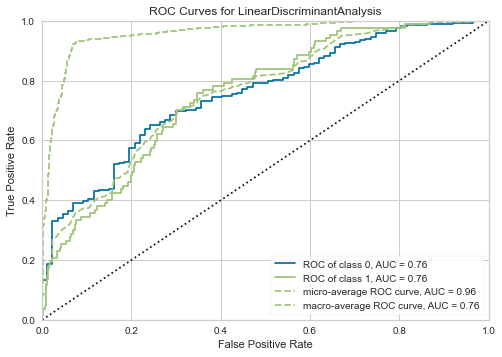

In [25]:
plot_model ( tuned_lda ,  plot  =  'auc' )

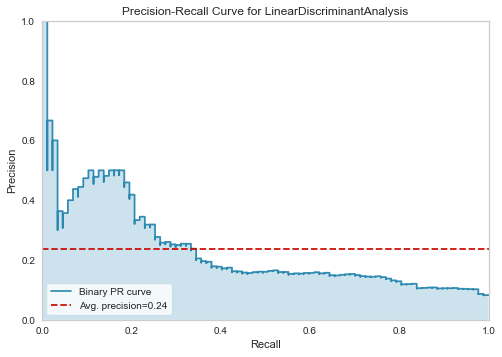

In [26]:
plot_model ( tuned_lda ,  plot  =  'pr' )

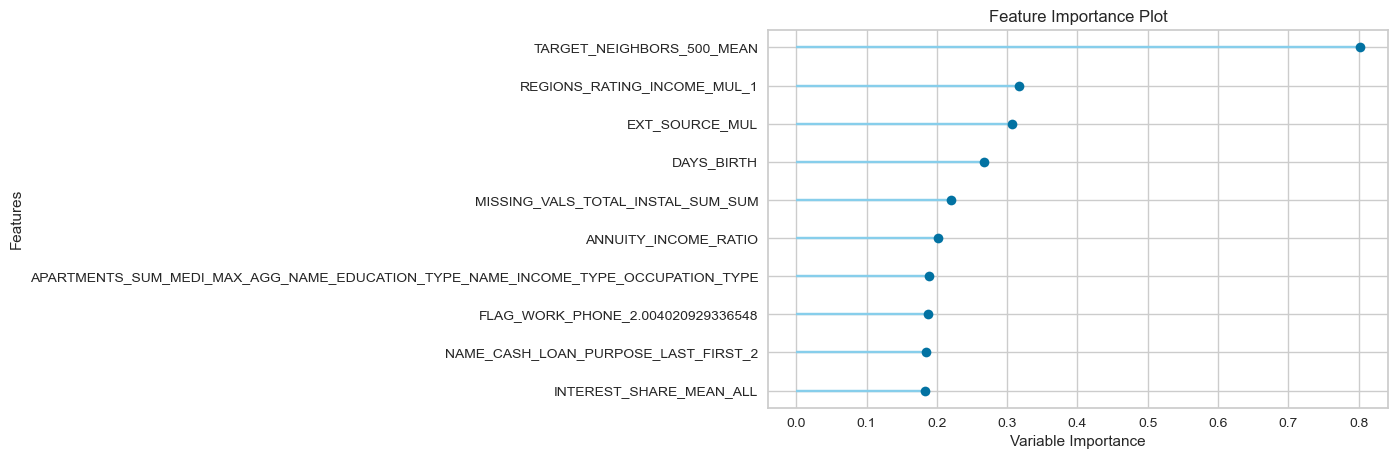

In [27]:
plot_model ( tuned_lda ,  plot = 'feature' )

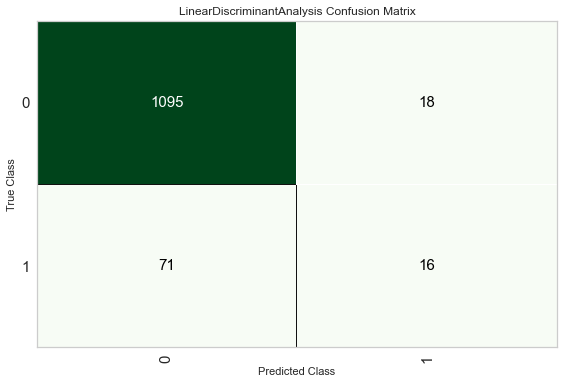

In [28]:
plot_model ( tuned_lda ,  plot  =  'confusion_matrix' )

**Finalisation du modèle LDA**

In [37]:
final_lda  =  finalize_model ( tuned_lda )

In [38]:
print(final_lda)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.1,
                           solver='lsqr', store_covariance=False, tol=0.0001)


**Prédire avec le modèle LDA**

In [43]:
pm_lda = predict_model ( final_lda )
pm_lda

EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                           -0.002416                 -0.212160   
1                           -0.002416                 -2.148110   
2                           -0.002416                  0.170704   
3                           -0.002416                  0.571216   
4                           -0.002416                  0.911982   
...                               ...                       ...   
1195                        -0.002416                  0.081300   
1196                        -0.002416                  0.147296   
1197                        -0.002416                  0.149808   
1198                        -0.002416                  0.211576   
1199                        -0.002416                  0.043369   

      CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                         0.000000         -0.971864   
1                         0.000000          1.018575   
2                        -0.224504          1.018575   
3                         0.000000          1.018575   
4                         0.000000          1.018575   
...                            ...               ...   
1195                      0.000000         -0.971864   
1196                      0.000000         -0.971864   
1197                      0.000000         -0.971864   
1198                      0.000000          1.018575   
1199                      0.000000         -0.971864   

      MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                             -0.032451               -0.075677   
1                             -0.032451               -0.075677   
2                             -0.032451               -0.075677   
3                             -0.032451               -0.075677   
4                             -0.032451               -0.075677   
...                                 ...                     ...   
1195                          -0.032451               -0.075677   
1196                          -0.032451               -0.075677   
1197                          -0.032451               -0.075677   
1198                          -0.032451               -0.075677   
1199                          -0.032451               -0.075677   

      EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                                0.000000   
1                               -0.006163   
2                                0.000000   
3                                0.000000   
4                                0.000000   
...                                   ...   
1195                             0.000000   
1196                             0.000000   
1197                             0.000000   
1198                             0.000000   
1199                             0.000000   

      APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
0                                       0.033994   
1                                      -0.017091   
2                                      -0.141896   
3                                      -0.065916   
4                                      -0.130041   
...                                          ...   
1195                                   -0.119446   
1196                                   -0.137091   
1197                                   -0.106307   
1198                                    1.899774   
1199                                   -0.119656   

      SK_DPD_RATIO_MEAN_YEAR_1_MEAN  TOTAL_TERM_MEAN_YEAR_1_SUM  ...  \
0                         -0.054239                   -0.037594  ...   
1                         -0.054239                    1.777176  ...   
2                         -0.054239                    0.189253  ...   
3                          0.000000                   -0.806350  ...   
4                         -0.054239                   -0.589586  ...   
...                             ...                         ...  ...   
1195                      -0.054239                  

**Prédictions sur le unseen_data**

In [47]:
unseen_predictions_lda  =  predict_model ( final_lda ,  data = test_sample_std ) 
unseen_predictions_lda.head()

AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  EXP_AMT_PAYMENT_RATIO_LAST_MEAN  \
38424                          -0.032768                        -0.004855   
3298                           -0.032768                        -0.004855   
6474                           -0.032768                        -0.004856   
28971                          -0.032768                        -0.004855   
33424                           0.000000                        -0.004855   

       AMT_DECLINED_SUM_FIRST_2  CNT_INSTALMENT_MEAN_REST_MAX  \
38424                 -2.455377                           0.0   
3298                   0.187496                           0.0   
6474                   0.262878                           0.0   
28971                  0.125792                           0.0   
33424                  0.604565                           0.0   

       HOUSETYPE_MODE_0  MISSING_VALS_TOTAL_INSTAL_SUM_SUM  \
38424         -1.003499                          -0.044103   
3298          -1.003499                          -0.044103   
6474          -1.003499                          -0.044103   
28971          0.985322                          -0.044103   
33424          0.985322                          -0.044103   

       CONTRACT_APPROVED_MEAN  EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
38424               -0.076727                            -0.013239   
3298                -0.076727                            -0.013239   
6474                -0.076727                             0.000000   
28971               -0.076727                             0.000000   
33424               -0.076727                             0.000000   

       APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
38424                                   -0.070976   
3298                                     0.110338   
6474                                    -0.094552   
28971                                   -0.103835   
33424                                   -0.063448   

       SK_DPD_RATIO_MEAN_YEAR_1_MEAN  ...  SELLERPLACE_AREA_MIN_FIRST_2  \
38424                      -0.042563  ...                     -0.113035   
3298                       -0.042563  ...                     -0.108409   
6474                       -0.042563  ...                     -0.099997   
28971                      -0.042563  ...                     -0.113035   
33424                      -0.042563  ...                     -0.066351   

       ANNUITY_SUM_FIRST_2  AMT_DECLINED_SUM_ALL  \
38424            -0.249204             -0.390136   
3298             -0.249205              0.070431   
6474             -0.249205              0.290995   
28971            -0.249205             -0.293871   
33424            -0.249204              0.560390   

       CNT_INSTALMENT_MAX_YEAR_1_MEAN  AMT_ANNUITY_MEAN_CREDITACTIVE_CLOSED  \
38424                        3.617618                             -0.059158   
3298                        -0.505722                              0.000000   
6474                         0.752982                              0.000000   
28971                        0.362350                              0.000000   
33424                       -1.156775                             -0.059158   

       DAYS_FIRST_LAST_DUE_DIFF_MEAN_ALL  \
38424                          -0.994134   
3298                            0.013330   
6474                            1.155122   
28971                           0.006994   
33424                          -0.899090   

       STATUS_MEAN_MEAN_CREDITACTIVE_ACTIVE  ANNUITY_GOODS_MEAN_FIRST_2  \
38424                              0.618682                   -0.170971   
3298                              -0.523236                   -0.170972   
6474                               0.000000                   -0.170972   
28971                              0.000000                   -0.170972   
33424                              0.000000                   -0.170967   

       Label   Score  
38424      0  0.7992  
3298       1  0.7943  
6474       0  0.

**Sauvegarde du modèle LDA**

In [52]:
save_model ( final_lda ,  'Save_Model/Final LDA Model 17sept2021' )

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='TARGET',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                 ('dummy', Dummify(target='TARGET')),
                 ('fix_perfect', Remove_100(target='TARGET')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('d

## [5. Modèle XGBOOST](#plan)<a class="anchor" id="5"></a>

**Création du moèle XGBOOST**

In [16]:
xgboost = create_model('xgboost')

**Réglage du modèle XGBOOST**

In [19]:
tuned_xgboost  =  tune_model ( xgboost )

In [22]:
print(tuned_xgboost)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0.2,
              reg_lambda=0.001, scale_pos_weight=1.6, subsample=0.2,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)


**Tracés**

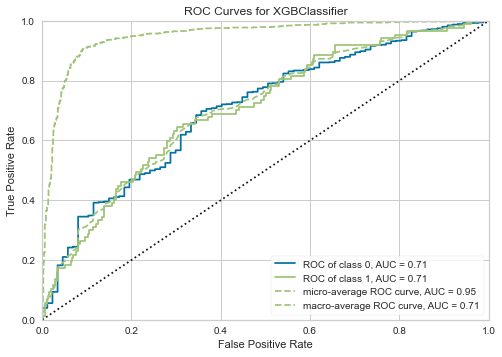

In [29]:
plot_model ( tuned_xgboost ,  plot  =  'auc' )

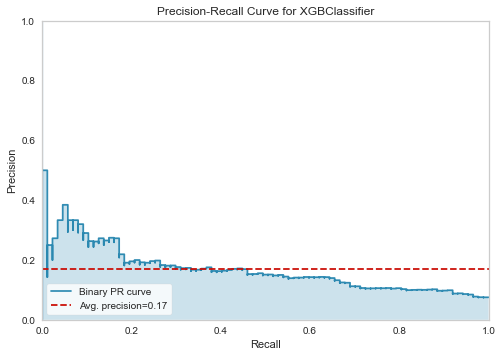

In [30]:
plot_model ( tuned_xgboost ,  plot  =  'pr' )

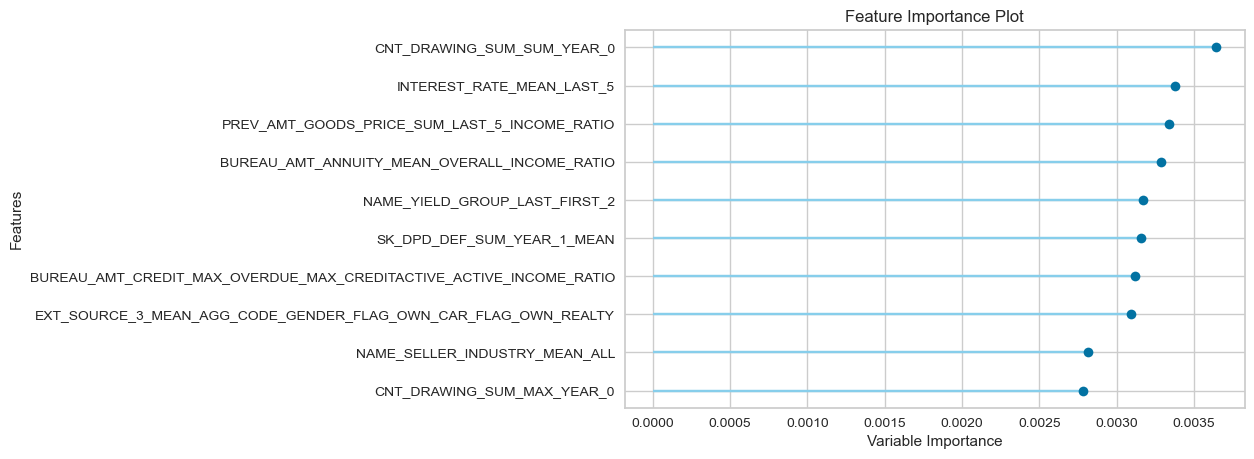

In [31]:
plot_model ( tuned_xgboost ,  plot = 'feature' )

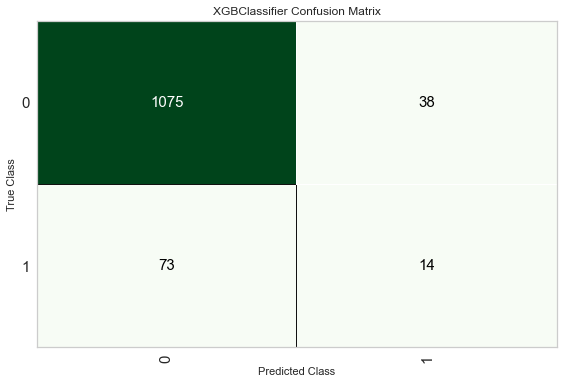

In [32]:
plot_model ( tuned_xgboost ,  plot  =  'confusion_matrix' )

**Finalisation du modèle XGBOOST**

In [39]:
final_xgboost  =  finalize_model ( tuned_xgboost )

In [42]:
print(final_xgboost)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0.2,
              reg_lambda=0.001, scale_pos_weight=1.6, subsample=0.2,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)


**Prédire avec le modèle XGBOOST**

In [44]:
pm_xgboost = predict_model ( final_xgboost )
pm_xgboost

EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                           -0.002416                 -0.212160   
1                           -0.002416                 -2.148110   
2                           -0.002416                  0.170704   
3                           -0.002416                  0.571216   
4                           -0.002416                  0.911982   
...                               ...                       ...   
1195                        -0.002416                  0.081300   
1196                        -0.002416                  0.147296   
1197                        -0.002416                  0.149808   
1198                        -0.002416                  0.211576   
1199                        -0.002416                  0.043369   

      CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                         0.000000         -0.971864   
1                         0.000000          1.018575   
2                        -0.224504          1.018575   
3                         0.000000          1.018575   
4                         0.000000          1.018575   
...                            ...               ...   
1195                      0.000000         -0.971864   
1196                      0.000000         -0.971864   
1197                      0.000000         -0.971864   
1198                      0.000000          1.018575   
1199                      0.000000         -0.971864   

      MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                             -0.032451               -0.075677   
1                             -0.032451               -0.075677   
2                             -0.032451               -0.075677   
3                             -0.032451               -0.075677   
4                             -0.032451               -0.075677   
...                                 ...                     ...   
1195                          -0.032451               -0.075677   
1196                          -0.032451               -0.075677   
1197                          -0.032451               -0.075677   
1198                          -0.032451               -0.075677   
1199                          -0.032451               -0.075677   

      EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                                0.000000   
1                               -0.006163   
2                                0.000000   
3                                0.000000   
4                                0.000000   
...                                   ...   
1195                             0.000000   
1196                             0.000000   
1197                             0.000000   
1198                             0.000000   
1199                             0.000000   

      APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
0                                       0.033994   
1                                      -0.017091   
2                                      -0.141896   
3                                      -0.065916   
4                                      -0.130041   
...                                          ...   
1195                                   -0.119446   
1196                                   -0.137091   
1197                                   -0.106307   
1198                                    1.899774   
1199                                   -0.119656   

      SK_DPD_RATIO_MEAN_YEAR_1_MEAN  TOTAL_TERM_MEAN_YEAR_1_SUM  ...  \
0                         -0.054239                   -0.037594  ...   
1                         -0.054239                    1.777176  ...   
2                         -0.054239                    0.189253  ...   
3                          0.000000                   -0.806350  ...   
4                         -0.054239                   -0.589586  ...   
...                             ...                         ...  ...   
1195                      -0.054239                  

**Prédictions sur le unseen_data**

In [48]:
unseen_predictions_xgboost  =  predict_model ( final_xgboost ,  data = test_sample_std ) 
unseen_predictions_xgboost.head()

AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  EXP_AMT_PAYMENT_RATIO_LAST_MEAN  \
38424                          -0.032768                        -0.004855   
3298                           -0.032768                        -0.004855   
6474                           -0.032768                        -0.004856   
28971                          -0.032768                        -0.004855   
33424                           0.000000                        -0.004855   

       AMT_DECLINED_SUM_FIRST_2  CNT_INSTALMENT_MEAN_REST_MAX  \
38424                 -2.455377                           0.0   
3298                   0.187496                           0.0   
6474                   0.262878                           0.0   
28971                  0.125792                           0.0   
33424                  0.604565                           0.0   

       HOUSETYPE_MODE_0  MISSING_VALS_TOTAL_INSTAL_SUM_SUM  \
38424         -1.003499                          -0.044103   
3298          -1.003499                          -0.044103   
6474          -1.003499                          -0.044103   
28971          0.985322                          -0.044103   
33424          0.985322                          -0.044103   

       CONTRACT_APPROVED_MEAN  EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
38424               -0.076727                            -0.013239   
3298                -0.076727                            -0.013239   
6474                -0.076727                             0.000000   
28971               -0.076727                             0.000000   
33424               -0.076727                             0.000000   

       APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
38424                                   -0.070976   
3298                                     0.110338   
6474                                    -0.094552   
28971                                   -0.103835   
33424                                   -0.063448   

       SK_DPD_RATIO_MEAN_YEAR_1_MEAN  ...  SELLERPLACE_AREA_MIN_FIRST_2  \
38424                      -0.042563  ...                     -0.113035   
3298                       -0.042563  ...                     -0.108409   
6474                       -0.042563  ...                     -0.099997   
28971                      -0.042563  ...                     -0.113035   
33424                      -0.042563  ...                     -0.066351   

       ANNUITY_SUM_FIRST_2  AMT_DECLINED_SUM_ALL  \
38424            -0.249204             -0.390136   
3298             -0.249205              0.070431   
6474             -0.249205              0.290995   
28971            -0.249205             -0.293871   
33424            -0.249204              0.560390   

       CNT_INSTALMENT_MAX_YEAR_1_MEAN  AMT_ANNUITY_MEAN_CREDITACTIVE_CLOSED  \
38424                        3.617618                             -0.059158   
3298                        -0.505722                              0.000000   
6474                         0.752982                              0.000000   
28971                        0.362350                              0.000000   
33424                       -1.156775                             -0.059158   

       DAYS_FIRST_LAST_DUE_DIFF_MEAN_ALL  \
38424                          -0.994134   
3298                            0.013330   
6474                            1.155122   
28971                           0.006994   
33424                          -0.899090   

       STATUS_MEAN_MEAN_CREDITACTIVE_ACTIVE  ANNUITY_GOODS_MEAN_FIRST_2  \
38424                              0.618682                   -0.170971   
3298                              -0.523236                   -0.170972   
6474                               0.000000                   -0.170972   
28971                              0.000000                   -0.170972   
33424                              0.000000                   -0.170967   

       Label   Score  
38424      0  0.9818  
3298       1  0.8338  
6474       1  0.

**Sauvegarde du modèle XGBOOST**

In [51]:
save_model ( final_xgboost ,  'Save_Model/Final XGBOOST Model 17sept2021' )

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='TARGET',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                                interaction_constraints='', learning_rate=0.15,
                                max_delta_step=0, max_depth=5,
                                min_child_weight=2, missing=nan,
                                monotone_constraints='()', n_estim

## [6. Modèle Lightgbm](#plan)<a class="anchor" id="6"></a>

**Création du modèle LightGbm**

In [17]:
lightgbm = create_model('lightgbm')

**Réglage du modèle LightGbm**

In [23]:
tuned_lightgbm  =  tune_model ( lightgbm )

In [ ]:
print(tuned_lightgbm)

**Tracés**

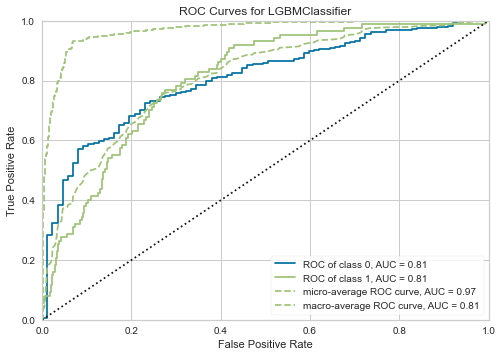

In [33]:
plot_model ( tuned_lightgbm ,  plot  =  'auc' )

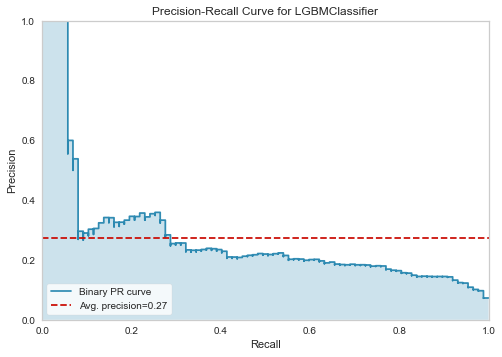

In [34]:
plot_model ( tuned_lightgbm ,  plot  =  'pr' )

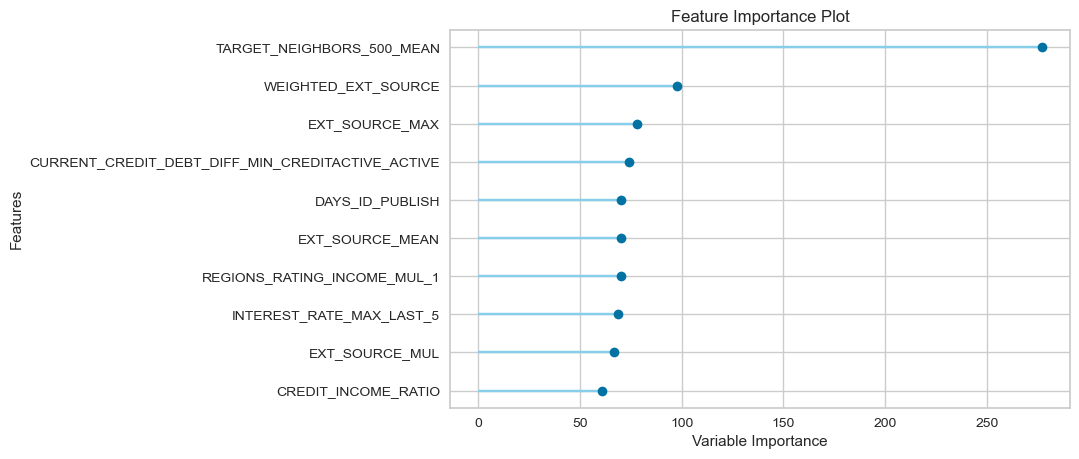

In [35]:
plot_model ( tuned_lightgbm ,  plot = 'feature' )

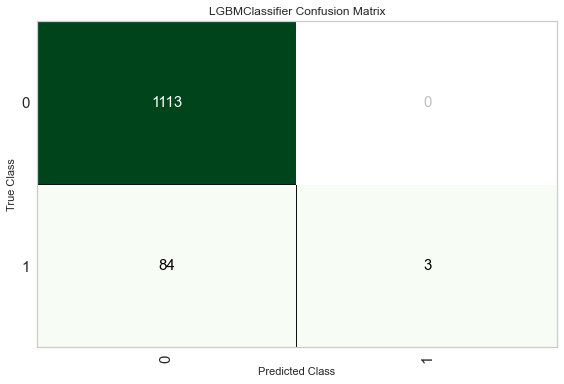

In [36]:
plot_model ( tuned_lightgbm ,  plot  =  'confusion_matrix' )

**Finalisation du modèle LightGbm**

In [40]:
final_lightgbm  =  finalize_model ( tuned_lightgbm)

In [41]:
print(final_lightgbm)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               min_child_samples=56, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=260, n_jobs=-1, num_leaves=50, objective=None,
               random_state=1, reg_alpha=0.1, reg_lambda=1e-06, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


**Prédire avec le modèle LightGbm**

In [45]:
pm_lightgbm = predict_model ( final_lightgbm )
pm_lightgbm

EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                           -0.002416                 -0.212160   
1                           -0.002416                 -2.148110   
2                           -0.002416                  0.170704   
3                           -0.002416                  0.571216   
4                           -0.002416                  0.911982   
...                               ...                       ...   
1195                        -0.002416                  0.081300   
1196                        -0.002416                  0.147296   
1197                        -0.002416                  0.149808   
1198                        -0.002416                  0.211576   
1199                        -0.002416                  0.043369   

      CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                         0.000000         -0.971864   
1                         0.000000          1.018575   
2                        -0.224504          1.018575   
3                         0.000000          1.018575   
4                         0.000000          1.018575   
...                            ...               ...   
1195                      0.000000         -0.971864   
1196                      0.000000         -0.971864   
1197                      0.000000         -0.971864   
1198                      0.000000          1.018575   
1199                      0.000000         -0.971864   

      MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                             -0.032451               -0.075677   
1                             -0.032451               -0.075677   
2                             -0.032451               -0.075677   
3                             -0.032451               -0.075677   
4                             -0.032451               -0.075677   
...                                 ...                     ...   
1195                          -0.032451               -0.075677   
1196                          -0.032451               -0.075677   
1197                          -0.032451               -0.075677   
1198                          -0.032451               -0.075677   
1199                          -0.032451               -0.075677   

      EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                                0.000000   
1                               -0.006163   
2                                0.000000   
3                                0.000000   
4                                0.000000   
...                                   ...   
1195                             0.000000   
1196                             0.000000   
1197                             0.000000   
1198                             0.000000   
1199                             0.000000   

      APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
0                                       0.033994   
1                                      -0.017091   
2                                      -0.141896   
3                                      -0.065916   
4                                      -0.130041   
...                                          ...   
1195                                   -0.119446   
1196                                   -0.137091   
1197                                   -0.106307   
1198                                    1.899774   
1199                                   -0.119656   

      SK_DPD_RATIO_MEAN_YEAR_1_MEAN  TOTAL_TERM_MEAN_YEAR_1_SUM  ...  \
0                         -0.054239                   -0.037594  ...   
1                         -0.054239                    1.777176  ...   
2                         -0.054239                    0.189253  ...   
3                          0.000000                   -0.806350  ...   
4                         -0.054239                   -0.589586  ...   
...                             ...                         ...  ...   
1195                      -0.054239                  

**Prédictions sur le unseen_data**

In [49]:
unseen_predictions_lightgbm  =  predict_model ( final_lightgbm ,  data = test_sample_std ) 
unseen_predictions_lightgbm.head()

AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  EXP_AMT_PAYMENT_RATIO_LAST_MEAN  \
38424                          -0.032768                        -0.004855   
3298                           -0.032768                        -0.004855   
6474                           -0.032768                        -0.004856   
28971                          -0.032768                        -0.004855   
33424                           0.000000                        -0.004855   

       AMT_DECLINED_SUM_FIRST_2  CNT_INSTALMENT_MEAN_REST_MAX  \
38424                 -2.455377                           0.0   
3298                   0.187496                           0.0   
6474                   0.262878                           0.0   
28971                  0.125792                           0.0   
33424                  0.604565                           0.0   

       HOUSETYPE_MODE_0  MISSING_VALS_TOTAL_INSTAL_SUM_SUM  \
38424         -1.003499                          -0.044103   
3298          -1.003499                          -0.044103   
6474          -1.003499                          -0.044103   
28971          0.985322                          -0.044103   
33424          0.985322                          -0.044103   

       CONTRACT_APPROVED_MEAN  EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
38424               -0.076727                            -0.013239   
3298                -0.076727                            -0.013239   
6474                -0.076727                             0.000000   
28971               -0.076727                             0.000000   
33424               -0.076727                             0.000000   

       APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
38424                                   -0.070976   
3298                                     0.110338   
6474                                    -0.094552   
28971                                   -0.103835   
33424                                   -0.063448   

       SK_DPD_RATIO_MEAN_YEAR_1_MEAN  ...  SELLERPLACE_AREA_MIN_FIRST_2  \
38424                      -0.042563  ...                     -0.113035   
3298                       -0.042563  ...                     -0.108409   
6474                       -0.042563  ...                     -0.099997   
28971                      -0.042563  ...                     -0.113035   
33424                      -0.042563  ...                     -0.066351   

       ANNUITY_SUM_FIRST_2  AMT_DECLINED_SUM_ALL  \
38424            -0.249204             -0.390136   
3298             -0.249205              0.070431   
6474             -0.249205              0.290995   
28971            -0.249205             -0.293871   
33424            -0.249204              0.560390   

       CNT_INSTALMENT_MAX_YEAR_1_MEAN  AMT_ANNUITY_MEAN_CREDITACTIVE_CLOSED  \
38424                        3.617618                             -0.059158   
3298                        -0.505722                              0.000000   
6474                         0.752982                              0.000000   
28971                        0.362350                              0.000000   
33424                       -1.156775                             -0.059158   

       DAYS_FIRST_LAST_DUE_DIFF_MEAN_ALL  \
38424                          -0.994134   
3298                            0.013330   
6474                            1.155122   
28971                           0.006994   
33424                          -0.899090   

       STATUS_MEAN_MEAN_CREDITACTIVE_ACTIVE  ANNUITY_GOODS_MEAN_FIRST_2  \
38424                              0.618682                   -0.170971   
3298                              -0.523236                   -0.170972   
6474                               0.000000                   -0.170972   
28971                              0.000000                   -0.170972   
33424                              0.000000                   -0.170967   

       Label   Score  
38424      0  0.8601  
3298       0  0.6233  
6474       0  0.

**Sauvegarde du modèle LightGbm**

In [50]:
save_model ( final_lightgbm ,  'Save_Model/Final LightGbm Model 17sept2021' )

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='TARGET',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=0.01,
                                 max_depth=-1

In [ ]:
# Chargement du modèle LightGbm et nouvelles prédictions**

# save_final_lightgbm  =  load_model ( 'Save_Model/Final LightGbm Model 17sept2021' )

# new_prediction_lightgbm  =  predict_model ( save_final_lightgbm ,  data = test_sample_std ) # data = data_unseen

# new_prediction_lightgbm.head()

## [7. Tester les 3 modèles](#plan)<a class="anchor" id="7"></a>

### **Prédictions avec Lightgbm**

In [7]:
data = pd.read_csv('data_pycaret/test_df_std.csv').drop("Unnamed: 0",axis=1)

In [9]:
data.shape

(48744, 1242)

In [8]:
# Chargement du modèle LightGbm et nouvelles prédictions**

save_final_lightgbm  =  load_model ( 'Save_Model/Final LightGbm Model 17sept2021' )

new_prediction_lightgbm  =  predict_model ( save_final_lightgbm ,  data = data ) # data = data_unseen

new_prediction_lightgbm.head()

Transformation Pipeline and Model Successfully Loaded


SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0      100001                           0.000000   
1      100005                           0.000000   
2      100013                          -0.032768   
3      100028                          -0.032768   
4      100038                           0.000000   

   EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                        -0.004855                  0.275682   
1                        -0.004855                  0.323084   
2                        -0.004855                 -0.561517   
3                        -0.004855                 -2.861579   
4                        -0.004855                 -0.649952   

   CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                      0.000000          0.985322   
1                      0.000000         -1.003499   
2                     -0.481604         -1.003499   
3                      0.000000          0.985322   
4                      0.000000         -1.003499   

   MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                          -0.044103               -0.076727   
1                          -0.044103               -0.076727   
2                          -0.044103               -0.076727   
3                          -0.044103               -0.076727   
4                          -0.044103               -0.076727   

   EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                             0.000000   
1                             0.000000   
2                            -0.013239   
3                            -0.013239   
4                             0.000000   

   APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
0                                   -0.127721                       0.000000   
1                                   -0.124166                      -0.042563   
2                                   -0.094018                      -0.042563   
3                                   -0.121488                      -0.042563   
4                                    0.359312                      -0.042563   

   TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
0                   -0.870309          0.000000            -1.120705   
1                   -0.374946          0.000000            -0.585517   
2                    0.791712         -0.446913             1.176868   
3                   -0.647355         -0.548741             0.108152   
4                   -0.443859          0.000000            -0.629494   

   EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
0                                    -0.516887                     -0.321866   
1                                     0.355217                     -0.321866   
2                                     0.006794                      0.781784   
3                                     0.093638                     -0.321866   
4                                     0.000000                     -0.321866   

   EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                          -0.615394                              
1                                          -2.096986                              
2                                          -0.891222                              
3                                          -0.977911                              
4                                          -0.615394                              

   YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
0                     -0.116865                -1.145212   
1                      0.000000                 0.561945   
2                      0.000000                 0.052181   
3                      0.366310                -0.399714   
4                      0.000000                 0.424078   

   CREDIT_ANNUITY_RATIO  AMT_REQ_CREDIT_BUREAU_WEEK  \
0              1.668029               

In [20]:
x = new_prediction_lightgbm['Label'].value_counts()
print('Pourcentage Target 0 : ', round((x[0] / (x[0]+x[1])) *100,2), ' %' )
print('Pourcentage Target 1 : ', round((x[1] / (x[0]+x[1])) *100,2), ' %' )

Pourcentage Target 0 :  99.82  %
Pourcentage Target 1 :  0.18  %


### **Prédictions avec Xgboost**

In [11]:
# Chargement du modèle XGBOOST et nouvelles prédictions**

save_final_xgboost  =  load_model ( 'Save_Model/Final XGBOOST Model 17sept2021' )

new_prediction_xgboost  =  predict_model ( save_final_xgboost ,  data = data ) # data = data_unseen

new_prediction_xgboost.head()

Transformation Pipeline and Model Successfully Loaded


SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0      100001                           0.000000   
1      100005                           0.000000   
2      100013                          -0.032768   
3      100028                          -0.032768   
4      100038                           0.000000   

   EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                        -0.004855                  0.275682   
1                        -0.004855                  0.323084   
2                        -0.004855                 -0.561517   
3                        -0.004855                 -2.861579   
4                        -0.004855                 -0.649952   

   CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                      0.000000          0.985322   
1                      0.000000         -1.003499   
2                     -0.481604         -1.003499   
3                      0.000000          0.985322   
4                      0.000000         -1.003499   

   MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                          -0.044103               -0.076727   
1                          -0.044103               -0.076727   
2                          -0.044103               -0.076727   
3                          -0.044103               -0.076727   
4                          -0.044103               -0.076727   

   EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                             0.000000   
1                             0.000000   
2                            -0.013239   
3                            -0.013239   
4                             0.000000   

   APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
0                                   -0.127721                       0.000000   
1                                   -0.124166                      -0.042563   
2                                   -0.094018                      -0.042563   
3                                   -0.121488                      -0.042563   
4                                    0.359312                      -0.042563   

   TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
0                   -0.870309          0.000000            -1.120705   
1                   -0.374946          0.000000            -0.585517   
2                    0.791712         -0.446913             1.176868   
3                   -0.647355         -0.548741             0.108152   
4                   -0.443859          0.000000            -0.629494   

   EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
0                                    -0.516887                     -0.321866   
1                                     0.355217                     -0.321866   
2                                     0.006794                      0.781784   
3                                     0.093638                     -0.321866   
4                                     0.000000                     -0.321866   

   EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                          -0.615394                              
1                                          -2.096986                              
2                                          -0.891222                              
3                                          -0.977911                              
4                                          -0.615394                              

   YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
0                     -0.116865                -1.145212   
1                      0.000000                 0.561945   
2                      0.000000                 0.052181   
3                      0.366310                -0.399714   
4                      0.000000                 0.424078   

   CREDIT_ANNUITY_RATIO  AMT_REQ_CREDIT_BUREAU_WEEK  \
0              1.668029               

In [18]:
x = new_prediction_xgboost['Label'].value_counts()
print('Pourcentage Target 0 : ', round((x[0] / (x[0]+x[1])) *100,2), ' %' )
print('Pourcentage Target 1 : ', round((x[1] / (x[0]+x[1])) *100,2), ' %' )

Pourcentage Target 0 :  81.16  %
Pourcentage Target 1 :  18.84  %


### **Prédictions avec LDA**

In [19]:
# Chargement du modèle LDA et nouvelles prédictions**

save_final_lda  =  load_model ( 'Save_Model/Final LDA Model 17sept2021' )

new_prediction_lda  =  predict_model ( save_final_lda ,  data = data ) # data = data_unseen

new_prediction_lda.head()

Transformation Pipeline and Model Successfully Loaded


SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0      100001                           0.000000   
1      100005                           0.000000   
2      100013                          -0.032768   
3      100028                          -0.032768   
4      100038                           0.000000   

   EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                        -0.004855                  0.275682   
1                        -0.004855                  0.323084   
2                        -0.004855                 -0.561517   
3                        -0.004855                 -2.861579   
4                        -0.004855                 -0.649952   

   CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                      0.000000          0.985322   
1                      0.000000         -1.003499   
2                     -0.481604         -1.003499   
3                      0.000000          0.985322   
4                      0.000000         -1.003499   

   MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                          -0.044103               -0.076727   
1                          -0.044103               -0.076727   
2                          -0.044103               -0.076727   
3                          -0.044103               -0.076727   
4                          -0.044103               -0.076727   

   EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                             0.000000   
1                             0.000000   
2                            -0.013239   
3                            -0.013239   
4                             0.000000   

   APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
0                                   -0.127721                       0.000000   
1                                   -0.124166                      -0.042563   
2                                   -0.094018                      -0.042563   
3                                   -0.121488                      -0.042563   
4                                    0.359312                      -0.042563   

   TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
0                   -0.870309          0.000000            -1.120705   
1                   -0.374946          0.000000            -0.585517   
2                    0.791712         -0.446913             1.176868   
3                   -0.647355         -0.548741             0.108152   
4                   -0.443859          0.000000            -0.629494   

   EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
0                                    -0.516887                     -0.321866   
1                                     0.355217                     -0.321866   
2                                     0.006794                      0.781784   
3                                     0.093638                     -0.321866   
4                                     0.000000                     -0.321866   

   EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                          -0.615394                              
1                                          -2.096986                              
2                                          -0.891222                              
3                                          -0.977911                              
4                                          -0.615394                              

   YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
0                     -0.116865                -1.145212   
1                      0.000000                 0.561945   
2                      0.000000                 0.052181   
3                      0.366310                -0.399714   
4                      0.000000                 0.424078   

   CREDIT_ANNUITY_RATIO  AMT_REQ_CREDIT_BUREAU_WEEK  \
0              1.668029               

In [21]:
x = new_prediction_lda['Label'].value_counts()
print('Pourcentage Target 0 : ', round((x[0] / (x[0]+x[1])) *100,2), ' %' )
print('Pourcentage Target 1 : ', round((x[1] / (x[0]+x[1])) *100,2), ' %' )

Pourcentage Target 0 :  96.13  %
Pourcentage Target 1 :  3.87  %


## [8. Préparation des jeux de données pour le dashboard avec le framework Streamlit](#plan)<a class="anchor" id="8"></a>

In [19]:
test_df_std = pd.read_csv('data_pycaret/test_df_std.csv').drop("Unnamed: 0",axis=1)
test_df = pd.read_csv('data_pycaret/test_df.csv').drop("Unnamed: 0",axis=1)
train_df = pd.read_csv('data_pycaret/train_df.csv').drop("Unnamed: 0",axis=1)
train_df_std = pd.read_csv('data_pycaret/train_df_std.csv').drop("Unnamed: 0",axis=1)

In [43]:
application_train = pd.read_csv('data/application_train.csv')
application_test = pd.read_csv('data/application_test.csv')

In [49]:
test_df_std[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'CNT_CHILDREN', 'AMT_GOODS_PRICE']].head()

AMT_INCOME_TOTAL  AMT_CREDIT  CNT_CHILDREN  AMT_GOODS_PRICE
0         -0.427809    0.142475     -0.559988        -0.037477
1         -0.782413   -0.804537     -0.559988        -0.839362
2          0.237075    0.401002     -0.559988         0.497113
3          1.345214    2.896221      2.260729         3.303709
4          0.015447    0.297651      0.850370         0.483748

In [48]:
test_df[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_CONTRACT_TYPE']] = application_test[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_CONTRACT_TYPE']]
train_df[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_CONTRACT_TYPE']] = application_train[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_CONTRACT_TYPE']]
print(test_df.shape)
print(train_df.shape)

(48744, 1245)
(307507, 1246)


In [50]:
display(test_df_std.head(2))
print('test_df_std: ',test_df_std.shape)
display(test_df.head(2))
print('test_df : ', test_df.shape)
display(train_df_std.head(2))
print('train_df_std : ', train_df_std.shape)
display(train_df.head(2))
print('train_df : ', train_df.shape)

SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0      100001                                0.0   
1      100005                                0.0   

   EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                        -0.004855                  0.275682   
1                        -0.004855                  0.323084   

   CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                           0.0          0.985322   
1                           0.0         -1.003499   

   MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                          -0.044103               -0.076727   
1                          -0.044103               -0.076727   

   EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                                  0.0   
1                                  0.0   

   APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
0                                   -0.127721                       0.000000   
1                                   -0.124166                      -0.042563   

   TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
0                   -0.870309               0.0            -1.120705   
1                   -0.374946               0.0            -0.585517   

   EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
0                                    -0.516887                     -0.321866   
1                                     0.355217                     -0.321866   

   EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                          -0.615394                              
1                                          -2.096986                              

   YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
0                     -0.116865                -1.145212   
1                      0.000000                 0.561945   

   CREDIT_ANNUITY_RATIO  AMT_REQ_CREDIT_BUREAU_WEEK  \
0              1.668029                    -0.05158   
1             -0.690363                    -0.05158   

   TOTAL_TERM_MEAN_REST_MEAN  DAYS_FIRST_DUE_MAX_LAST_5  \
0                        0.0                  -1.809917   
1                        0.0                  -0.096968   

   AMT_CREDIT_GOODS_DIFF_SUM_LAST_5  DAYS_TERMINATION_MAX_LAST_5  \
0                         -0.428303                    -1.704361   
1                         -0.463863                     0.213408   

   DAYS_DETAILS_CHANGE_MUL  AMT_CREDIT_MAX_OVERDUE_SUM_CREDITACTIVE_CLOSED  \
0                 0.400466                                       -0.052912   
1                 0.669655                                       -0.052912   

   AGE_EMPLOYED_DIFF_MEAN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY  \
0                                           0.949556                     
1                                          -1.565737                     

   RATE_DOWN_PAYMENT_MEAN_LAST_5  FLAG_DOCUMENT_14  \
0                       0.318833               0.0   
1                       0.368037               0.0   

   AMT_DRAWINGS_ATM_CURRENT_MAX  \
0                           0.0   
1                           0.0   

   APARTMENTS_SUM_MEDI_MIN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY  \
0                                          -1.303019                      
1                                           0.839792                      

   SK_DPD_RATIO_MEAN_YEAR_0_MAX  SELLERPLACE_AREA_MEAN_LAST_5  \
0                           0.0                     -0.146876   
1                           0.0                     -0.148945   

   CREDIT_ACTIVE_Bad debt_MEAN_OVERALL  OCCUPATION_TYPE_0  \
0                            -0.004861           0.695343   
1                            -0.004861          -4.239521   

   CNT_INSTALMENT_FUTURE_MEAN_YEAR_0_MEAN  DAYS_FIRST_DUE_MEAN_LAST_5  \
0                                     0.0                   -1.266421   
1              

test_df_std:  (48744, 1242)


SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0      100001                                0.0   
1      100005                                0.0   

   EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                              1.0                    1048.5   
1                              1.0                    4464.0   

   CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                           0.0            0.9307   
1                           0.0            0.9087   

   MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                                0.0                     0.0   
1                                0.0                     0.0   

   EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                                  0.0   
1                                  0.0   

   APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
0                                   14.273276                            0.0   
1                                   29.469948                            0.0   

   TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
0                        0.00               0.0                  6.0   
1                       18.33               0.0                 18.9   

   EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
0                                       0.4995                           0.0   
1                                       1.3330                           0.0   

   EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                             0.4988                              
1                                             0.4424                              

   YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
0                         0.973                  -1709.0   
1                         0.000                   -706.0   

   CREDIT_ANNUITY_RATIO  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                 27.67                         0.0   
1                 12.83                         0.0   

   TOTAL_TERM_MEAN_REST_MEAN  DAYS_FIRST_DUE_MAX_LAST_5  \
0                        0.0                    -1709.0   
1                        0.0                     -706.0   

   AMT_CREDIT_GOODS_DIFF_SUM_LAST_5  DAYS_TERMINATION_MAX_LAST_5  \
0                           -1048.5                      -1612.0   
1                           -4464.0                       -460.0   

   DAYS_DETAILS_CHANGE_MUL  AMT_CREDIT_MAX_OVERDUE_SUM_CREDITACTIVE_CLOSED  \
0            -7.304590e+09                                             0.0   
1             0.000000e+00                                             0.0   

   AGE_EMPLOYED_DIFF_MEAN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY  \
0                                             2668.0                     
1                                             2084.0                     

   RATE_DOWN_PAYMENT_MEAN_LAST_5  FLAG_DOCUMENT_14  \
0                        0.10430                 0   
1                        0.10895                 0   

   AMT_DRAWINGS_ATM_CURRENT_MAX  \
0                           0.0   
1                           0.0   

   APARTMENTS_SUM_MEDI_MIN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY  \
0                                             0.1183                      
1                                             1.1150                      

   SK_DPD_RATIO_MEAN_YEAR_0_MAX  SELLERPLACE_AREA_MEAN_LAST_5  \
0                           0.0                          23.0   
1                           0.0                          18.0   

   CREDIT_ACTIVE_Bad debt_MEAN_OVERALL  OCCUPATION_TYPE_0  \
0                                  0.0             0.9350   
1                                  0.0             0.8286   

   CNT_INSTALMENT_FUTURE_MEAN_YEAR_0_MEAN  DAYS_FIRST_DUE_MEAN_LAST_5  \
0                                     0.0                     -1709.0   
1              

test_df :  (48744, 1245)


SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0      100002                          -0.009648   
1      100003                           0.000000   

   EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                        -0.002416                  0.271139   
1                        -0.002416                  0.129771   

   CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                           0.0          1.018575   
1                           0.0          1.018575   

   MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                          -0.032451               -0.075677   
1                          -0.032451               -0.075677   

   EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                                  0.0   
1                                  0.0   

   APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
0                                   -0.095605                      -0.054239   
1                                   -0.041137                      -0.054239   

   TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
0                    0.315278               0.0             0.215638   
1                   -0.197142               0.0            -0.563662   

   EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
0                                    -0.581926                     -0.325048   
1                                     0.000000                     -0.325048   

   EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                          -0.977137                              
1                                           0.060468                              

   YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
0                     -0.095820                 0.772289   
1                      0.121187                -0.417991   

   CREDIT_ANNUITY_RATIO  AMT_REQ_CREDIT_BUREAU_WEEK  \
0             -0.657259                   -0.167879   
1              1.866958                   -0.167879   

   TOTAL_TERM_MEAN_REST_MEAN  DAYS_FIRST_DUE_MAX_LAST_5  \
0                        0.0                   0.116259   
1                        0.0                  -0.139756   

   AMT_CREDIT_GOODS_DIFF_SUM_LAST_5  DAYS_TERMINATION_MAX_LAST_5  \
0                         -0.412664                     0.941615   
1                          1.079202                     0.098700   

   DAYS_DETAILS_CHANGE_MUL  AMT_CREDIT_MAX_OVERDUE_SUM_CREDITACTIVE_CLOSED  \
0                 0.292826                                        0.005874   
1                 0.646250                                       -0.019664   

   AGE_EMPLOYED_DIFF_MEAN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY  \
0                                          -1.535953                     
1                                           0.223369                     

   RATE_DOWN_PAYMENT_MEAN_LAST_5  FLAG_DOCUMENT_14  \
0                      -0.836008         -0.054269   
1                      -0.297616         -0.054269   

   AMT_DRAWINGS_ATM_CURRENT_MAX  \
0                           0.0   
1                           0.0   

   APARTMENTS_SUM_MEDI_MIN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY  \
0                                           0.834224                      
1                                           0.332171                      

   SK_DPD_RATIO_MEAN_YEAR_0_MAX  SELLERPLACE_AREA_MEAN_LAST_5  \
0                     -0.057078                      0.096035   
1                      0.000000                      0.117724   

   CREDIT_ACTIVE_Bad debt_MEAN_OVERALL  OCCUPATION_TYPE_0  \
0                            -0.007254          -1.156419   
1                            -0.007254           0.807244   

   CNT_INSTALMENT_FUTURE_MEAN_YEAR_0_MEAN  DAYS_FIRST_DUE_MEAN_LAST_5  \
0                                0.015427                    0.579448   
1              

train_df_std :  (307507, 1243)


SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0      100002                                1.0   
1      100003                                0.0   

   EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                              1.0                       0.0   
1                              1.0                  -10381.5   

   CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                           0.0            0.9307   
1                           0.0            0.9307   

   MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                                0.0                     0.0   
1                                0.0                     0.0   

   EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                                  0.0   
1                                  0.0   

   APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
0                                    295.4703                            0.0   
1                                    547.8121                            0.0   

   TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
0                       44.50               0.0                39.00   
1                       24.17               0.0                19.25   

   EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
0                                       0.2085                           0.0   
1                                       0.0000                           0.0   

   EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                             0.4834                              
1                                             0.5230                              

   YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
0                         0.972                   -565.0   
1                         0.985                  -1274.0   

   CREDIT_ANNUITY_RATIO  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                 16.47                         0.0   
1                 36.22                         0.0   

   TOTAL_TERM_MEAN_REST_MEAN  DAYS_FIRST_DUE_MAX_LAST_5  \
0                        0.0                     -565.0   
1                        0.0                     -716.0   

   AMT_CREDIT_GOODS_DIFF_SUM_LAST_5  DAYS_TERMINATION_MAX_LAST_5  \
0                               0.0                        -17.0   
1                          146263.5                       -527.0   

   DAYS_DETAILS_CHANGE_MUL  AMT_CREDIT_MAX_OVERDUE_SUM_CREDITACTIVE_CLOSED  \
0            -8.770084e+09                                        8364.645   
1            -2.857643e+08                                           0.000   

   AGE_EMPLOYED_DIFF_MEAN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY  \
0                                             2084.0                     
1                                             2496.0                     

   RATE_DOWN_PAYMENT_MEAN_LAST_5  FLAG_DOCUMENT_14  \
0                        0.00000                 0   
1                        0.05002                 0   

   AMT_DRAWINGS_ATM_CURRENT_MAX  \
0                           0.0   
1                           0.0   

   APARTMENTS_SUM_MEDI_MIN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY  \
0                                              1.115                      
1                                              0.881                      

   SK_DPD_RATIO_MEAN_YEAR_0_MAX  SELLERPLACE_AREA_MEAN_LAST_5  \
0                           0.0                         500.0   
1                           0.0                         533.0   

   CREDIT_ACTIVE_Bad debt_MEAN_OVERALL  OCCUPATION_TYPE_0  \
0                                  0.0              0.894   
1                                  0.0              0.937   

   CNT_INSTALMENT_FUTURE_MEAN_YEAR_0_MEAN  DAYS_FIRST_DUE_MEAN_LAST_5  \
0                                    11.0                      -565.0   
1              

train_df :  (307507, 1246)


**Echantillons**

In [51]:
test_df_sample = test_df.sample(n=10000).sort_values(by=['SK_ID_CURR'])
list_indices_test_df_sample = test_df_sample['SK_ID_CURR'].tolist()
list_indices_test_df_sample

[100001,
 100005,
 100109,
 100222,
 100223,
 100271,
 100358,
 100382,
 100384,
 100385,
 100466,
 100483,
 100484,
 100512,
 100548,
 100553,
 100607,
 100613,
 100618,
 100677,
 100744,
 100745,
 100754,
 100760,
 100765,
 100770,
 100792,
 100823,
 100836,
 100931,
 100970,
 101008,
 101026,
 101041,
 101051,
 101056,
 101064,
 101118,
 101125,
 101140,
 101169,
 101186,
 101193,
 101225,
 101258,
 101269,
 101343,
 101353,
 101478,
 101580,
 101643,
 101700,
 101714,
 101762,
 101827,
 101863,
 101880,
 101897,
 101903,
 101920,
 101921,
 101961,
 101962,
 101971,
 102029,
 102062,
 102273,
 102315,
 102346,
 102374,
 102380,
 102387,
 102403,
 102413,
 102441,
 102445,
 102449,
 102458,
 102476,
 102509,
 102562,
 102568,
 102582,
 102592,
 102652,
 102720,
 102731,
 102733,
 102755,
 102763,
 103025,
 103083,
 103112,
 103132,
 103146,
 103147,
 103171,
 103173,
 103184,
 103206,
 103280,
 103315,
 103334,
 103377,
 103404,
 103418,
 103453,
 103460,
 103474,
 103480,
 103525,
 

In [52]:
test_df_sample

SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0          100001                              0.000   
1          100005                              0.000   
16         100109                              1.000   
29         100222                              1.000   
30         100223                              1.000   
...           ...                                ...   
48714      455963                              1.000   
48718      456009                              1.000   
48722      456028                              1.000   
48728      456119                              3.014   
48734      456168                              0.000   

       EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                             1.000000                    1048.5   
1                             1.000000                    4464.0   
16                            1.000000                 -177925.5   
29                            0.999997                  -35640.0   
30                            1.000000                     337.5   
...                                ...                       ...   
48714                         1.000000                   -8739.0   
48718                         1.000000                    2902.5   
48722                         1.000021                 -183748.5   
48728                         1.270331                 -160573.5   
48734                         1.000000                     702.0   

       CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                               0.0            0.9307   
1                               0.0            0.9087   
16                              0.0            0.9087   
29                              0.0            0.9087   
30                              0.0            0.9087   
...                             ...               ...   
48714                           0.0            0.9087   
48718                           0.0            0.9307   
48722                          12.0            0.9087   
48728                           0.0            0.9087   
48734                           0.0            0.9087   

       MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                                    0.0                     0.0   
1                                    0.0                     0.0   
16                                   0.0                     0.0   
29                                   0.0                     0.0   
30                                   0.0                     0.0   
...                                  ...                     ...   
48714                                0.0                     0.0   
48718                                0.0                     0.0   
48722                                0.0                     0.0   
48728                                0.0                     0.0   
48734                                0.0                     0.0   

       EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                             0.000000e+00   
1                             0.000000e+00   
16                            1.232402e-14   
29                            0.000000e+00   
30                            0.000000e+00   
...                                    ...   
48714                         0.000000e+00   
48718                         0.000000e+00   
48722                         0.000000e+00   
48728                         1.673929e-12   
48734                         0.000000e+00   

       APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
0                                       14.273276   
1                                       29.469948   
16                                     451.747770   
29                                     463.917540   
30                                     383.151640   
...                                           ...   
48714                                  487.356480   
48718                                 

In [53]:
test_df_std_sample = test_df_std.loc[test_df_std['SK_ID_CURR'].isin(list_indices_test_df_sample)]
test_df_std_sample = test_df_std_sample.sort_values(by=['SK_ID_CURR'])
test_df_std_sample

SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0          100001                           0.000000   
1          100005                           0.000000   
16         100109                          -0.032768   
29         100222                          -0.032768   
30         100223                          -0.032768   
...           ...                                ...   
48714      455963                          -0.032768   
48718      456009                          -0.032768   
48722      456028                          -0.032768   
48728      456119                           0.008844   
48734      456168                           0.000000   

       EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                            -0.004855                  0.275682   
1                            -0.004855                  0.323084   
16                           -0.004855                 -2.208246   
29                           -0.004855                 -0.233507   
30                           -0.004855                  0.265814   
...                                ...                       ...   
48714                        -0.004855                  0.139844   
48718                        -0.004855                  0.301413   
48722                        -0.004855                 -2.289062   
48728                        -0.004852                 -1.967423   
48734                        -0.004855                  0.270873   

       CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                          0.000000          0.985322   
1                          0.000000         -1.003499   
16                         0.000000         -1.003499   
29                         0.000000         -1.003499   
30                         0.000000         -1.003499   
...                             ...               ...   
48714                      0.000000         -1.003499   
48718                      0.000000          0.985322   
48722                     -0.214158         -1.003499   
48728                      0.000000         -1.003499   
48734                      0.000000         -1.003499   

       MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                              -0.044103               -0.076727   
1                              -0.044103               -0.076727   
16                             -0.044103               -0.076727   
29                             -0.044103               -0.076727   
30                             -0.044103               -0.076727   
...                                  ...                     ...   
48714                          -0.044103               -0.076727   
48718                          -0.044103               -0.076727   
48722                          -0.044103               -0.076727   
48728                          -0.044103               -0.076727   
48734                          -0.044103               -0.076727   

       EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                                 0.000000   
1                                 0.000000   
16                               -0.013239   
29                                0.000000   
30                                0.000000   
...                                    ...   
48714                             0.000000   
48718                             0.000000   
48722                             0.000000   
48728                            -0.013239   
48734                            -0.013239   

       APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
0                                       -0.127721   
1                                       -0.124166   
16                                      -0.025400   
29                                      -0.022554   
30                                      -0.041444   
...                                           ...   
48714                                   -0.017072   
48718                                 

In [54]:
train_df_sample = train_df.sample(n=10000).sort_values(by=['SK_ID_CURR'])
train_df_sample

SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
9           100012                                1.0   
37          100044                                1.0   
58          100069                                1.0   
120         100140                                0.0   
155         100182                                1.0   
...            ...                                ...   
307313      456037                                1.0   
307324      456048                                1.0   
307384      456109                                1.0   
307423      456156                                1.0   
307443      456181                                1.0   

        EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
9                              0.894234                -28485.000   
37                             0.888249                -48294.000   
58                             0.990872                 -9548.325   
120                            0.000000                     0.000   
155                            0.969506                -95841.000   
...                                 ...                       ...   
307313                         1.000000                  -882.000   
307324                         0.982251                -29700.000   
307384                         1.000000                 -5193.000   
307423                         0.960480                   513.000   
307443                         0.999727                -86467.500   

        CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
9                                0.0            0.9087   
37                               0.0            0.9087   
58                               0.0            0.9087   
120                              0.0            0.9307   
155                              0.0            0.9307   
...                              ...               ...   
307313                           0.0            0.9307   
307324                           0.0            0.9307   
307384                           6.0            0.9087   
307423                          24.0            0.9087   
307443                           0.0            0.9087   

        MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
9                                     0.0                     0.0   
37                                    0.0                     0.0   
58                                    0.0                     0.0   
120                                   0.0                     0.0   
155                                   0.0                     0.0   
...                                   ...                     ...   
307313                                0.0                     0.0   
307324                                0.0                     0.0   
307384                                0.0                     0.0   
307423                                0.0                     0.0   
307443                                0.0                     0.0   

        EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
9                                       0.0   
37                                      0.0   
58                                      0.0   
120                                     0.0   
155                                     0.0   
...                                     ...   
307313                                  0.0   
307324                                  0.0   
307384                                  0.0   
307423                                  0.0   
307443                                  0.0   

        APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
9                                        87.740974   
37                                      186.647080   
58                                      342.107800   
120                                       0.000000   
155                                     288.698700   
...                                            ...   
307313                   

In [55]:
list_indices_train_df_sample = train_df_sample['SK_ID_CURR'].tolist()
list_indices_train_df_sample

[100012,
 100044,
 100069,
 100140,
 100182,
 100238,
 100240,
 100246,
 100251,
 100260,
 100295,
 100304,
 100337,
 100362,
 100415,
 100465,
 100490,
 100516,
 100579,
 100589,
 100637,
 100669,
 100689,
 100724,
 100775,
 100790,
 100811,
 100827,
 100835,
 100840,
 100869,
 100882,
 100892,
 100895,
 100947,
 101000,
 101032,
 101108,
 101163,
 101179,
 101188,
 101331,
 101500,
 101542,
 101546,
 101579,
 101591,
 101632,
 101639,
 101645,
 101647,
 101679,
 101708,
 101725,
 101746,
 101831,
 101833,
 101834,
 101868,
 101904,
 101935,
 101955,
 102023,
 102065,
 102083,
 102085,
 102091,
 102149,
 102190,
 102199,
 102242,
 102251,
 102269,
 102276,
 102288,
 102329,
 102399,
 102408,
 102446,
 102618,
 102623,
 102627,
 102633,
 102683,
 102759,
 102791,
 102823,
 102840,
 102861,
 102923,
 102976,
 102988,
 103031,
 103037,
 103047,
 103106,
 103189,
 103314,
 103316,
 103352,
 103407,
 103421,
 103443,
 103531,
 103576,
 103587,
 103611,
 103657,
 103680,
 103692,
 103730,
 

In [56]:
train_df_std_sample = train_df_std.loc[train_df_std['SK_ID_CURR'].isin(list_indices_train_df_sample)]
train_df_std_sample = train_df_std_sample.sort_values(by=['SK_ID_CURR'])
train_df_std_sample

SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
9           100012                          -0.009648   
37          100044                          -0.009648   
58          100069                          -0.009648   
120         100140                           0.000000   
155         100182                          -0.009648   
...            ...                                ...   
307313      456037                          -0.009648   
307324      456048                          -0.009648   
307384      456109                          -0.009648   
307423      456156                          -0.009648   
307443      456181                          -0.009648   

        EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
9                             -0.002416                 -0.116750   
37                            -0.002416                 -0.386495   
58                            -0.002416                  0.141116   
120                            0.000000                  0.000000   
155                           -0.002416                 -1.033957   
...                                 ...                       ...   
307313                        -0.002416                  0.259128   
307324                        -0.002416                 -0.133295   
307384                        -0.002416                  0.200424   
307423                        -0.002416                  0.278124   
307443                        -0.002416                 -0.906315   

        CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
9                           0.000000         -0.971864   
37                          0.000000         -0.971864   
58                          0.000000         -0.971864   
120                         0.000000          1.018575   
155                         0.000000          1.018575   
...                              ...               ...   
307313                      0.000000          1.018575   
307324                      0.000000          1.018575   
307384                     -0.739176         -0.971864   
307423                      0.804840         -0.971864   
307443                      0.000000         -0.971864   

        MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
9                               -0.032451               -0.075677   
37                              -0.032451               -0.075677   
58                              -0.032451               -0.075677   
120                              0.000000                0.000000   
155                             -0.032451               -0.075677   
...                                   ...                     ...   
307313                          -0.032451               -0.075677   
307324                          -0.032451               -0.075677   
307384                          -0.032451               -0.075677   
307423                          -0.032451               -0.075677   
307443                          -0.032451               -0.075677   

        EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
9                                       0.0   
37                                      0.0   
58                                      0.0   
120                                     0.0   
155                                     0.0   
...                                     ...   
307313                                  0.0   
307324                                  0.0   
307384                                  0.0   
307423                                  0.0   
307443                                  0.0   

        APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  \
9                                        -0.140444   
37                                       -0.119095   
58                                       -0.085538   
120                                       0.000000   
155                                      -0.097067   
...                                            ...   
307313                   

### **Prédiction sur le jeu test_df_std_sample avec le modèle xgboost**

In [57]:
# Chargement du modèle XGBOOST et nouvelles prédictions**

%time save_final_xgboost  =  load_model ( 'Save_Model/Final XGBOOST Model 17sept2021' )

%time new_prediction_xgboost  =  predict_model ( save_final_xgboost ,  data = test_df_std_sample ) # data = data_unseen

new_prediction_xgboost.head()

Transformation Pipeline and Model Successfully Loaded
Wall time: 58.4 ms
Wall time: 42.6 s


SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
0       100001                           0.000000   
1       100005                           0.000000   
16      100109                          -0.032768   
29      100222                          -0.032768   
30      100223                          -0.032768   

    EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
0                         -0.004855                  0.275682   
1                         -0.004855                  0.323084   
16                        -0.004855                 -2.208246   
29                        -0.004855                 -0.233507   
30                        -0.004855                  0.265814   

    CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
0                            0.0          0.985322   
1                            0.0         -1.003499   
16                           0.0         -1.003499   
29                           0.0         -1.003499   
30                           0.0         -1.003499   

    MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
0                           -0.044103               -0.076727   
1                           -0.044103               -0.076727   
16                          -0.044103               -0.076727   
29                          -0.044103               -0.076727   
30                          -0.044103               -0.076727   

    EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
0                              0.000000   
1                              0.000000   
16                            -0.013239   
29                             0.000000   
30                             0.000000   

    APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
0                                    -0.127721                       0.000000   
1                                    -0.124166                      -0.042563   
16                                   -0.025400                       0.000000   
29                                   -0.022554                      -0.042563   
30                                   -0.041444                      -0.042563   

    TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
0                    -0.870309          0.000000            -1.120705   
1                    -0.374946          0.000000            -0.585517   
16                   -0.870309         -0.231509            -0.934012   
29                    0.007995          0.000000            -0.249469   
30                    1.805139          0.000000             1.959736   

    EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
0                                     -0.516887                     -0.321866   
1                                      0.355217                     -0.321866   
16                                    -0.392166                     -0.321866   
29                                     0.006794                     -0.321866   
30                                     0.455663                     -0.321866   

    EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
0                                           -0.615394                              
1                                           -2.096986                              
16                                          -1.019942                              
29                                          -0.615394                              
30                                           0.582489                              

    YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
0                      -0.116865                -1.145212   
1                       0.000000                 0.561945   
16                      0.000000                -2.491534   
29                      0.000000                 0.000000   
30                      0.185119                -0.273762   

    CREDIT_ANNUITY_RATIO  AMT_REQ_

In [58]:
x = new_prediction_xgboost['Label'].value_counts()
print('Pourcentage Target 0 : ', round((x[0] / (x[0]+x[1])) *100,2), ' %' )
print('Pourcentage Target 1 : ', round((x[1] / (x[0]+x[1])) *100,2), ' %' )

Pourcentage Target 0 :  82.05  %
Pourcentage Target 1 :  17.95  %


### **Prédiction sur le jeu test_df_std_sample avec le modèle lda**

In [30]:
# Chargement du modèle LDA et nouvelles prédictions**

%time save_final_lda  =  load_model ( 'Save_Model/Final LDA Model 17sept2021' )

%time new_prediction_lda  =  predict_model ( save_final_lda ,  data = test_df_std_sample ) # data = data_unseen

new_prediction_lda.head()

Transformation Pipeline and Model Successfully Loaded
Wall time: 52.4 ms
Wall time: 39.3 s


SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
3       100028                          -0.032768   
4       100038                           0.000000   
9       100067                          -0.032768   
27      100187                          -0.032768   
30      100223                          -0.032768   

    EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
3                         -0.004855                 -2.861579   
4                         -0.004855                 -0.649952   
9                         -0.004855                 -0.125337   
27                        -0.004855                 -0.230322   
30                        -0.004855                  0.265814   

    CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
3                            0.0          0.985322   
4                            0.0         -1.003499   
9                            0.0         -1.003499   
27                           0.0          0.985322   
30                           0.0         -1.003499   

    MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
3                           -0.044103               -0.076727   
4                           -0.044103               -0.076727   
9                           -0.044103               -0.076727   
27                          -0.044103               -0.076727   
30                          -0.044103               -0.076727   

    EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
3                             -0.013239   
4                              0.000000   
9                             -0.013239   
27                            -0.013239   
30                             0.000000   

    APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
3                                    -0.121488                      -0.042563   
4                                     0.359312                      -0.042563   
9                                    -0.043273                      -0.042563   
27                                   -0.048148                      -0.042563   
30                                   -0.041444                      -0.042563   

    TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
3                    -0.647355         -0.548741             0.108152   
4                    -0.443859          0.000000            -0.629494   
9                     0.382017         -0.355719            -0.589666   
27                    2.359146         -0.630457             2.913947   
30                    1.805139          0.000000             1.959736   

    EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
3                                      0.093638                     -0.321866   
4                                      0.000000                     -0.321866   
9                                      0.930690                     -0.321866   
27                                    -1.034080                     -0.321866   
30                                     0.455663                     -0.321866   

    EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
3                                           -0.977911                              
4                                           -0.615394                              
9                                           -0.977911                              
27                                          -0.019079                              
30                                           0.582489                              

    YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
3                       0.366310                -0.399714   
4                       0.000000                 0.424078   
9                       0.000000                -0.687360   
27                      0.358257                -0.248231   
30                      0.185119                -0.273762   

    CREDIT_ANNUITY_RATIO  AMT_REQ_

In [31]:
x = new_prediction_lda['Label'].value_counts()
print('Pourcentage Target 0 : ', round((x[0] / (x[0]+x[1])) *100,2), ' %' )
print('Pourcentage Target 1 : ', round((x[1] / (x[0]+x[1])) *100,2), ' %' )

Pourcentage Target 0 :  95.78  %
Pourcentage Target 1 :  4.22  %


**Prédiction sur le jeu test_df_std_sample avec le modèle lightgbm**

In [34]:
# Chargement du modèle LightGbm et nouvelles prédictions**

%time save_final_lightgbm  =  load_model ( 'Save_Model/Final LightGbm Model 17sept2021' )

%time new_prediction_lightgbm  =  predict_model ( save_final_lightgbm ,  data = test_df_std_sample ) # data = data_unseen

new_prediction_lightgbm.head()

Transformation Pipeline and Model Successfully Loaded
Wall time: 21.5 ms
Wall time: 40.2 s


SK_ID_CURR  AMT_PAYMENT_RATIO_MAX_LAST_1_YEAR  \
3       100028                          -0.032768   
4       100038                           0.000000   
9       100067                          -0.032768   
27      100187                          -0.032768   
30      100223                          -0.032768   

    EXP_AMT_PAYMENT_RATIO_LAST_MEAN  AMT_DECLINED_SUM_FIRST_2  \
3                         -0.004855                 -2.861579   
4                         -0.004855                 -0.649952   
9                         -0.004855                 -0.125337   
27                        -0.004855                 -0.230322   
30                        -0.004855                  0.265814   

    CNT_INSTALMENT_MEAN_REST_MAX  HOUSETYPE_MODE_0  \
3                            0.0          0.985322   
4                            0.0         -1.003499   
9                            0.0         -1.003499   
27                           0.0          0.985322   
30                           0.0         -1.003499   

    MISSING_VALS_TOTAL_INSTAL_SUM_SUM  CONTRACT_APPROVED_MEAN  \
3                           -0.044103               -0.076727   
4                           -0.044103               -0.076727   
9                           -0.044103               -0.076727   
27                          -0.044103               -0.076727   
30                          -0.044103               -0.076727   

    EXP_BALANCE_LIMIT_RATIO_LAST_YEAR_1  \
3                             -0.013239   
4                              0.000000   
9                             -0.013239   
27                            -0.013239   
30                             0.000000   

    APPLICATION_AMT_TO_DECISION_RATIO_MEAN_ALL  SK_DPD_RATIO_MEAN_YEAR_1_MEAN  \
3                                    -0.121488                      -0.042563   
4                                     0.359312                      -0.042563   
9                                    -0.043273                      -0.042563   
27                                   -0.048148                      -0.042563   
30                                   -0.041444                      -0.042563   

    TOTAL_TERM_MEAN_YEAR_1_SUM  AMT_BALANCE_MEAN  TOTAL_TERM_MEAN_MAX  \
3                    -0.647355         -0.548741             0.108152   
4                    -0.443859          0.000000            -0.629494   
9                     0.382017         -0.355719            -0.589666   
27                    2.359146         -0.630457             2.913947   
30                    1.805139          0.000000             1.959736   

    EXP_ENCODED_STATUS_LAST_YEAR_1_MEAN_OVERALL  CNT_INSTALMENT_MEAN_REST_SUM  \
3                                      0.093638                     -0.321866   
4                                      0.000000                     -0.321866   
9                                      0.930690                     -0.321866   
27                                    -1.034080                     -0.321866   
30                                     0.455663                     -0.321866   

    EXT_SOURCE_MEAN_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE  \
3                                           -0.977911                              
4                                           -0.615394                              
9                                           -0.977911                              
27                                          -0.019079                              
30                                           0.582489                              

    YEARS_BEGINEXPLUATATION_MEDI  DAYS_FIRST_DUE_MEAN_ALL  \
3                       0.366310                -0.399714   
4                       0.000000                 0.424078   
9                       0.000000                -0.687360   
27                      0.358257                -0.248231   
30                      0.185119                -0.273762   

    CREDIT_ANNUITY_RATIO  AMT_REQ_

In [35]:
x = new_prediction_lightgbm['Label'].value_counts()
print('Pourcentage Target 0 : ', round((x[0] / (x[0]+x[1])) *100,2), ' %' )
print('Pourcentage Target 1 : ', round((x[1] / (x[0]+x[1])) *100,2), ' %' )

Pourcentage Target 0 :  99.82  %
Pourcentage Target 1 :  0.18  %


**Sauvegarde des échantillons**

In [59]:
test_df_sample.to_csv('data_tableau_xgb/test_df_sample.csv')
test_df_std_sample.to_csv('data_tableau_xgb/test_df_std_sample.csv')
train_df_sample.to_csv('data_tableau_xgb/train_df_sample.csv')
train_df_std_sample.to_csv('data_tableau_xgb/train_df_std_sample.csv')